## Test

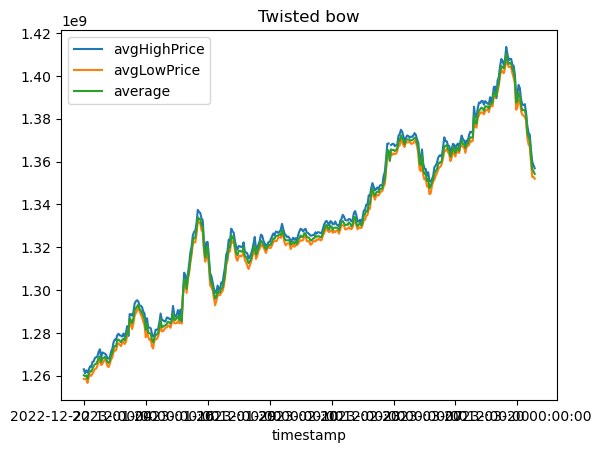

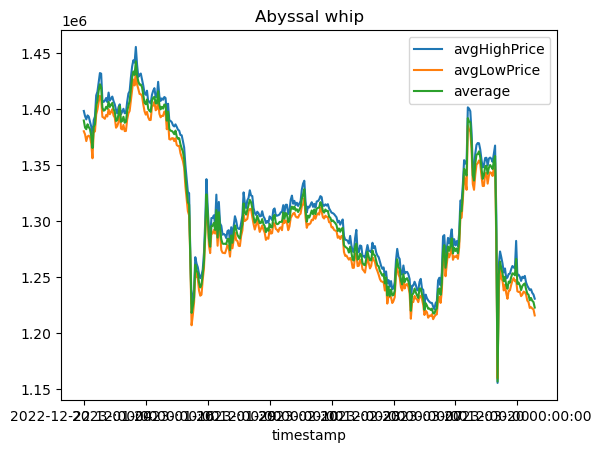

In [8]:
import DateTimeHelper

name1 = "Twisted bow"
data1 = DateTimeHelper.getDT(name1 , "6h")

name2 = "Abyssal whip"
data2 = DateTimeHelper.getDT(name2 , "6h")

# Creating a plot
res1 = data1.plot(title=name1).get_figure()
res2 = data2.plot(title=name2).get_figure()

# Save figure
path1 = "Graphs/" + name1 + ".png"
path2 = "Graphs/" + name2 + ".png"

res1.savefig(path1)
res2.savefig(path2)

## How does DateTimeHelper work?

##### Import everything needed
```py
import numpy as np
import NameIDHelper
from urllib.request import urlopen, Request
import json
from datetime import datetime
import pandas as pd
```

##### This function is used to replace all nan values while also adding an average col. This can be altered in the future to determine other ways of calculating averages
there are many times for smaller items that dont have enough trade volume that have null for some of the values   
if this is the case i want to set the value equal to the other val:
* highval = null, set highval = lowval
* lowval = null, set lowval = highval
* if both are null... remove row

```py
def addAverage(dt):
    # the volumes will still be there to calculate an average
    average = []
    for time in dt.values:
        averageVal = (time[3]*time[1] + time[2]*time[0]) / (time[3] + time[2])
        if (np.isnan(averageVal)):
            if time[0] == time[1]:
                # uh oh
                continue
            elif np.isnan(time[0]):
                averageVal = time[1]
            elif np.isnan(time[1]):
                averageVal = time[0]
        average.append(averageVal)
    dt['average'] = average
    return dt
```
##### This is a function that gets the DateTime formatted DataFrame
```py
def getDT(name,timestep):
    url = 'https://prices.runescape.wiki/api/v1/osrs'
    # we want the latest data, so lets add that to the url
    url += "/timeseries?timestep="
    url += timestep
    url += "&id="
    # lets add the abyssal whip to the url:
    url += str(NameIDHelper.NameToID(name))

    headers = {
        # the wiki blocks all common user-agents in order to prevent spam
        # after talking with some of the API maintainers over discord they asked me to include my discord in the user-agent
        'User-Agent': 'DateTimeHelper - @Be#9998',
    }
    req = Request(url, headers=headers)
    with urlopen(req) as response:
                latestData = response.read()
    data = json.loads(latestData)

    for date in data['data']:
        date['timestamp'] = datetime.utcfromtimestamp(date['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    data = data['data']
    
    dt_pandas = pd.DataFrame(data)
    dt_pandas = dt_pandas.set_index('timestamp')
    dt_pandas = addAverage(dt_pandas)
    dt_pandas.drop(columns=['lowPriceVolume', 'highPriceVolume'], inplace=True)
    return dt_pandas
```